# Project: Probabilistic IR with BIM25 model

In [34]:
import csv
import re

from nltk import PorterStemmer
from tqdm import tqdm 
import numpy as np
import scipy as sp # for sparse arrays
from time import sleep
import matplotlib.pyplot as plt 

## Prob IR system implementation

In [35]:
class Document:
    def __init__(self,title, text):
        self.title = title
        self.text = text
    def __repr__(self):
        return self.title

    def get_text(self):
        return self.text
    
    def to_int(self):
        return int(self.title)

In [36]:
def normalize(text, stemmer=False):
    
    normalized = re.sub(r'[^\w^\s^-]','',text).lower()
    if(stemmer):
        stemmer = PorterStemmer()
        normalized = stemmer.stem(normalized)
    
    return list(normalized.split())

def make_dict(corpus):
    dictionary = []
    dict_set = set()

    for doc in corpus:
        for word in doc:
            if(word in dict_set):
                continue
            else:
                dictionary.append(word)
                dict_set.add(word)
    return dictionary

def inverted_index(corpus,stemmer=False):
    """This function builds an inverse index based on the corpus,
        returning also the tf and idf for each word in two separate lists."""
    # may not work for large corpus, better switch to on-the-fly normalization
    corpus_norm = [normalize(text.get_text(), stemmer) for text in corpus]
    dictionary = make_dict(corpus_norm)
    inv_idx = {}
    n= len(corpus_norm)
    for token in dictionary:
        inv_idx[token] = []
    
    for i in tqdm(range(len(corpus_norm)), desc= "Computing reverse index"):
        for token in corpus_norm[i]:
            inv_idx[token].append(i)
    # remove duplicates

    tf = {}
    for key in tqdm(inv_idx.keys(), desc="Computing tf scores"):
        curr = 0
        count = np.zeros(n,dtype = int)
        doc_in_word = len(inv_idx[key])
        for i in range(doc_in_word):
            if(inv_idx[key][i]==curr):
                count[curr] += 1
            else:
                curr=inv_idx[key][i]
                count[curr]+=1
        tf[key] = sp.sparse.csr_matrix(count)
        inv_idx[key] = [*set(inv_idx[key])]
    
    idf={}
    for key in inv_idx.keys():
        idf[key]=np.log(n/len(inv_idx[key]))
    return inv_idx,tf,idf

def count_relevant(relevant, idx):
    """Return the number of relevant documents which contain the word indexed by "idx" """
    idx_set = set(idx)
    count = 0
    for element in relevant:
        if(element in idx_set):
            count+=1
    return int(count)

def ordered_print(list):
    for i in range(len(list)):
        print("{}. {}".format(i+1, list[i]))

In [37]:
class ProbIR:
    def __init__(self,corpus,index,tf,idf):
        self.corpus = corpus
        self.idx = index
        self.tf = tf
        self.idf = idf
    
    @classmethod
    def from_corpus(cls, corpus, stemmer = False):
        """Initialize ProbIR computing automatically the needed objects from a corpus."""
        idx, tf, idf = inverted_index(corpus,stemmer)
        return cls(corpus,idx,tf,idf)
    def rsv_scores(self, query,b,k,k2 = None, relevant = None, nonrelevant = None, test_mode = False):
        """Compute the RSV scores of the documents given a query. Relevance feedback is also available
            passing a list of relevant books and nonrelevant ones from the query."""
        avg = 0
        for i in range(len(self.corpus)):
            avg += len(self.corpus[i].get_text())
        avg /= len(self.corpus)

        scores = np.zeros(len(self.corpus))
        if(relevant == None):
            for word in query:
                try:
                    for d in range(len(self.corpus)):
                        l_d = len(self.corpus[d].get_text())
                        tf_td = self.tf[word].todense()[0,d]
                        num = (k+1)*tf_td
                        den = k*((1-b)+b*(l_d/avg)) + tf_td
                        if(k2 != None):
                            opt = ((k2+1)*tf_td)/(k2+tf_td)
                        else: 
                            opt = 1
                        
                        scores[d] += self.idf[word]*(num/den)*opt
                except KeyError:
                    if(test_mode == False):
                        print("Word {} not found, it will be ignored.".format(word))
                    continue
        else:
            vr = len(relevant)
            n = len(self.corpus)
            for word in query:
                try:
                    vr_t = count_relevant(relevant, self.idx[word])
                    vnr_t = count_relevant(nonrelevant, self.idx[word])
                    df_t = np.exp(self.idf[word])/n
                    for d in range(len(self.corpus)):
                        l_d = len(self.corpus[d].get_text())
                        tf_td = self.tf[word].todense()[0,d]
                        num = (k+1)*tf_td
                        den = np.abs(k*((1-b)+b*(l_d/avg)) + tf_td)
                        if(den == 0):
                            den = 1e-4
                        relevance_num = (vr_t + .5) /(vnr_t + .5)
                        relevance_den = np.abs((df_t - vr_t + .5)/(n - df_t - vr + vr_t + .5))
                        if(relevance_den == 0):
                            relevance_den = 1e-4

                        scores[d] += np.log(1e-4 + (relevance_num/(relevance_den))*(num/(den)))
                except KeyError:
                    if(test_mode == False):
                        print("Word {} not found, it will be ignored.".format(word))
                    continue
        
        return scores
    def query(self, query, stemmer = False, results = 5, b = .75, k = 1.6, k2 = None, pseudorel = 0, test_mode = False):
        """Submit a query to the IR system."""
        
        if(stemmer):
            query = normalize(query)
        else:
            query = query.split()
        if(test_mode == False):
            print(query)
        scores = self.rsv_scores(query,b,k,k2 = k2, test_mode = test_mode)
        idx_sorted = scores.argsort()[::-1]
        sel_books = [self.corpus[i] for i in idx_sorted[:results]]
        
        if(pseudorel > 0):
            if(test_mode == False):
                print("Computing pseudo-relevance feedback using first {} documents.".format(pseudorel))
            relevant = []
            for i in range(pseudorel):
                relevant.append(idx_sorted[i])
            nonrelevant = list(idx_sorted[:results])
            for elem in relevant:
                nonrelevant.remove(elem)
            if(test_mode == False):
                print(relevant,nonrelevant)
            sel_books = self.__pseudorel_qry(query, relevant, nonrelevant, stemmer,results, b, k,k2, test_mode)
        if(test_mode):
            return sel_books
        
        ordered_print(sel_books)
        sleep(1)
        ans = input("Are you satisfied with the obtained results? (y/n)")
        if(ans == "y"):
            return sel_books
        elif(ans == "n"):
            print("\nTo help us refine the results, pick the relevant results \n(enter the number of the book)")
            flag = True
            relevant = []
            while (flag):
                a = input()
                if(a == ""):
                    flag = False
                else:
                    relevant.append(idx_sorted[int(a)-1])
            nonrelevant = list(idx_sorted[:results])
            for elem in relevant:
                nonrelevant.remove(elem)
            sel_books = self.__query_relevance(query, relevant, nonrelevant, self.idx, stemmer,results, b, k)
            return sel_books
        else:
            return sel_books
    
    def __query_relevance(self, query, relevant, nonrelevant, stemmer=False, results=5, b=.75, k=1.6, k2 = None):
        """Internal method that implements the relevance scoring, iterates until the user is satisfied. """
        scores = self.rsv_scores(query, b, k, k2, relevant, nonrelevant)

        idx_sorted = scores.argsort()[::-1]
        sel_books = [self.corpus[i] for i in idx_sorted[:results]]

        ordered_print(sel_books)
        sleep(1)
        ans = input("Are you satisfied with the obtained results? (y/n)")
        if(ans == "y"):
            return sel_books
        elif(ans == "n"):
            print("\nTo help us refine the results, pick the relevant results \n(enter the number of the book)")
            flag = True
            relevant = []
            while (flag):
                a = input()
                if(a == ""):
                    flag = False
                else:
                    relevant.append(idx_sorted[int(a)-1])

            nonrelevant = list(idx_sorted[:results])
            for elem in relevant:
                nonrelevant.remove(elem)
            self.__query_relevance(query, relevant, nonrelevant, stemmer, results, b, k, k2)
    
    def __pseudorel_qry(self, query, relevant, nonrelevant, stemmer, results, b, k, k2, test_mode):
        """Internal method that implements the pseudo-relevance feedback."""
        scores = self.rsv_scores(query, b, k, k2, relevant, nonrelevant, test_mode)
        idx_sorted = scores.argsort()[::-1]
        sel_books = [self.corpus[i] for i in idx_sorted[:results]]
        return sel_books

    

In [29]:
import ProbIR as PIR
from tqdm import tqdm
import numpy as np

## Book test

In [38]:
data = []
with open("./booksummaries/booksummaries.txt", 'r',  encoding="utf8") as f:
    reader = PIR.csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)

16559it [00:00, 37069.91it/s]


In [39]:
books = []

for elem in data:
    tmp = PIR.Document(elem[2], elem[6])
    books.append(tmp)

In [40]:
idx,tf,idf = PIR.inverted_index(books)

Computing tf scores: 100%|██████████| 159109/159109 [00:26<00:00, 5976.31it/s]


In [52]:
import pickle

with open('booksummaries/idx.pkl', 'wb') as f:
    pickle.dump(idx, f)
with open('booksummaries/tf.pkl', 'wb') as f:
    pickle.dump(tf, f)
with open('booksummaries/idf.pkl', 'wb') as f:
    pickle.dump(idf, f)

In [46]:
with open('moviesummaries/idx.pkl', 'rb') as f:
    idx = pickle.load(f)
with open('moviesummaries/tf.pkl', 'rb') as f:
    tf = pickle.load(f)
with open('moviesummaries/idf.pkl', 'rb') as f:
    idf = pickle.load(f)

In [45]:
tf

{'old': <1x16559 sparse matrix of type '<class 'numpy.int32'>'
 	with 3686 stored elements in Compressed Sparse Row format>,
 'major': <1x16559 sparse matrix of type '<class 'numpy.int32'>'
 	with 851 stored elements in Compressed Sparse Row format>,
 'the': <1x16559 sparse matrix of type '<class 'numpy.int32'>'
 	with 16392 stored elements in Compressed Sparse Row format>,
 'boar': <1x16559 sparse matrix of type '<class 'numpy.int32'>'
 	with 40 stored elements in Compressed Sparse Row format>,
 'on': <1x16559 sparse matrix of type '<class 'numpy.int32'>'
 	with 11715 stored elements in Compressed Sparse Row format>,
 'manor': <1x16559 sparse matrix of type '<class 'numpy.int32'>'
 	with 122 stored elements in Compressed Sparse Row format>,
 'farm': <1x16559 sparse matrix of type '<class 'numpy.int32'>'
 	with 511 stored elements in Compressed Sparse Row format>,
 'calls': <1x16559 sparse matrix of type '<class 'numpy.int32'>'
 	with 1413 stored elements in Compressed Sparse Row forma

In [50]:
IR = PIR.ProbIR(books,idx,tf,idf)

In [51]:
IR.query("wizard school in england with magical creatures", results=10)

['wizard', 'school', 'in', 'england', 'with', 'magical', 'creatures']
1. House of Many Ways
2. Equal Rites
3. Magic Kingdom for Sale -- Sold!
4. The Secret of Platform 13
5. White Plume Mountain
6. Od Magic
7. The Dragon's Familiar
8. Fantastic Beasts and Where to Find Them
9. Wizard's First Rule
10. Ozoplaning with the Wizard of Oz

To help us refine the results, pick the relevant results 
(enter the number of the book)


[]

In [22]:
PIR.query("zombies pride",False,10)

['zombies', 'pride']
[Pride and Prejudice and Zombies: Dawn of the Dreadfuls, Pride and Prejudice and Zombies, Zombies Calling, World War Z, Bloody Bones, City Of The Dead, Dead Beat, The Laughing Corpse, Monster Nation, The Rising, Zombies: A Record of the Year of Infection]
To help us refine the results, pick the relevant results 
(enter the number of the book)
['zombies', 'pride']


C:\Users\andre\AppData\Local\Temp\ipykernel_12824\2934885440.py:35: RuntimeWarning: divide by zero encountered in log
  scores[d] += np.log((relevance_num/(relevance_den+ 1e-4))*(num/den))
C:\Users\andre\AppData\Local\Temp\ipykernel_12824\2934885440.py:35: RuntimeWarning: invalid value encountered in log
  scores[d] += np.log((relevance_num/(relevance_den+ 1e-4))*(num/den))


[Resident Evil: Caliban Cove, Ragtime, As I Walked Out One Midsummer Morning, Richard Carvel, Song of Lawino, Much Ado About Nothing, The Dark Ocean, Zombie Broadway, The Red Pony, Envy: A Luxe Novel, The Universal Baseball Association, Inc., J. Henry Waugh, Prop.]


## Movie test


In [53]:
data = []
with open("./moviesummaries/wiki_movie_plots_deduped_with_summaries.csv", 'r',  encoding="utf8",) as f:
    reader = csv.reader(f, dialect='excel-tab', delimiter=',' )
    for row in tqdm(reader):
        data.append(row)

34887it [00:00, 47350.04it/s]


In [55]:
movies = []

for elem in data:
    tmp = PIR.Document(elem[1], elem[7])
    movies.append(tmp)

In [56]:
idx,tf,idf = PIR.inverted_index(movies)

Computing tf scores: 100%|██████████| 185005/185005 [00:34<00:00, 5400.34it/s]


In [57]:
with open('moviesummaries/idx.pkl', 'wb') as f:
    pickle.dump(idx, f)
with open('moviesummaries/tf.pkl', 'wb') as f:
    pickle.dump(tf, f)
with open('moviesummaries/idf.pkl', 'wb') as f:
    pickle.dump(idf, f)

In [65]:
PIR = ProbIR.from_corpus(movies,stemmer=True)

NameError: name 'movies' is not defined

In [33]:
PIR.query("zombie blod",True)

AttributeError: module 'ProbIR' has no attribute 'query'

## Evaluating ProbIR

In [35]:
doc_set = []
doc_id = ""
doc_text = ""
with open('./cisi/CISI.ALL') as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")
doc_count = 0
for l in lines:
    if l.startswith(".I"):
        doc_id = int(l.split(" ")[1].strip())-1
    elif l.startswith(".X"):
        doc_set.append(doc_text.lstrip(" "))
        doc_id = ""
        doc_text = ""
    else:
        doc_text += l.strip()[3:] + " " # The first 3 characters of a line can be ignored.    

In [36]:
with open('./cisi/CISI.QRY') as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")
    
qry_set = {}
qry_id = ""
for l in lines:
    if l.startswith(".I"):
        qry_id = int(l.split(" ")[1].strip()) -1
    elif l.startswith(".W"):
        qry_set[qry_id] = l.strip()[3:]
        qry_id = ""

In [37]:
rel_set = {}
with open('./cisi/CISI.REL') as f:
    for l in f.readlines():
        qry_id = int(l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0]) -1
        doc_id = int(l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1])-1
        if qry_id in rel_set:
            rel_set[qry_id].append(doc_id)
        else:
            rel_set[qry_id] = []
            rel_set[qry_id].append(doc_id)

In [38]:
for i in range(len(doc_set)):
    doc_set[i] = Document(str(i),doc_set[i])

In [44]:
PIR = ProbIR.from_corpus(doc_set, stemmer=False)

Computing tf scores: 100%|██████████| 12504/12504 [00:00<00:00, 14800.77it/s]


In [63]:
B = 120
acc = np.zeros(B)
results = 15
skipped = 0
for j in tqdm(range(B)):
    try: 
        ret = PIR.query(qry_set[j], results=results, b=0.7,k=1.6, pseudorel=10, test_mode=True)
        idx = set([doc.to_int() for doc in ret])
        rel_set_toset = set(rel_set)
        acc[j] = len(idx.intersection(rel_set_toset))/results
    except KeyError:
        skipped += 1
        continue


print("MAP: ", np.sum(acc)/(B-skipped))

100%|██████████| 120/120 [02:28<00:00,  1.24s/it]

MAP:  0.06964285714285713


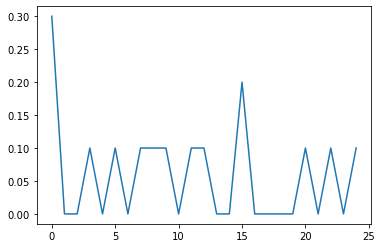

In [62]:
plt.plot(acc)

## Test with npl dataset

In [46]:
doc_set = []
qry_set = []

with open('./npl/doc-text') as f:
    lines = ""
    for l in f.readlines():
        if(l.strip().isnumeric()):
            continue
        lines += re.sub("\n","", l)
    doc_set = lines.lstrip().split("/")
corpus = [Document(i,doc_set[i]) for i in range(len(doc_set))]

with open('./npl/query-text') as f:
    lines = ""
    for l in f.readlines():
        if(l.strip().isnumeric()):
            continue
        lines += re.sub("\n","", l)
    qry_set = lines.lstrip().split("/")

with open('./npl/rlv-ass') as f:
    lines = ""
    for l in f.readlines():
        if(l.strip().isnumeric()):
            continue
        lines += re.sub("\n","", l)
    qry_set = lines.lstrip().split("/")


In [47]:
doc_set

['MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES',
 'MATHEMATICAL ANALYSIS AND DESIGN DETAILS OF WAVEGUIDE FED MICROWAVE RADIATIONS',
 'USE OF DIGITAL COMPUTERS IN THE DESIGN OF BAND PASS FILTERS HAVING GIVEN PHASE AND ATTENUATION CHARACTERISTICS',
 'SYSTEMS OF DATA CODING FOR INFORMATION TRANSFER',
 'USE OF PROGRAMS IN ENGINEERING TESTING OF COMPUTERS',
 'NUMBER REPRESENTATION IN BINARY MACHINES',
 'SECONDARY EMISSION OF ELECTRONS BY POSITIVE ION BOMBARDMENT OF THE CATHODE',
 'MEASUREMENT OF PLASMA TEMPERATURES IN ARC DISCHARGE USING SHOCK WAVE TECHNIQUES',
 'CHARACTERISTICS OF THE SINGLE ELECTRODE DISCHARGE IN THE RARE GASES AT LOW PRESSURES',
 'METHODS OF CALCULATING INSTANTANEOUS POWER DISSIPATION IN REACTIVE CIRCUITS',
 'THE EFFECT OF OXIDATION ON CIRCUIT BREAKER CONTACTS',
 'TEMPERATURE INDEPENDENT METHODS FOR TUNING HIGHLY STABLE HIGH FREQUENCY OSCILLATORS',
 'MATHEMATICAL EXPRESSIONS AND GRAPHS FOR THE DESIGN OF TRANSISTORISED TUNED PASS BAND A

## Varie ed eventuali

- Index creation normalizes (pre-processing) all the words first, maybe an on-the-fly optimization is better.